# 感染可能性予測モデル

## Datasetについて
- 元データは[ここ](https://www.covidanalytics.io/dataset)
- [Documentation](https://www.covidanalytics.io/dataset_documentation)
- 2019年１２月から2020年の４月
- MITの研究者が論文を読んで集めた数値データ
- 病院で行われた研究から得られたものである。無症状患者の有病率を考慮できていない。
- 各行はcohort、つまり研究対象となった集団である。
- 列は大まかに以下のカテゴリーである
    - 人口統計学的情報（例：コホート内の患者数、集計された年齢と性別の統計）
    - 併存疾患情報（糖尿病、高血圧の有病率など)
    - 症状（発熱、咳、咽頭痛などを含む)
    - 治療法（抗生物質、挿管などを含む)
    - 標準的な検査値（リンパ球数、血小板などを含む)
    - 転帰（退院、入院期間、死亡などを含む)
- 追加で以下も調査
    - 死亡率、ICUおよび入院期間
    - 主要症状（発熱、咳、息切れ、疲労、下痢）
    - 一般的な併存疾患（高血圧、糖尿病 
- 死亡率または退院率の報告には一貫性がない。死亡率のみを報告しているものもあれば、退院率のみを報告しているものもある


- 引用
@online{bertsimas2020covidClinicalOutcomes, author = {Bertsimas, Dimitris and Bandi, Hari and Boussioux, Leonard and Cory-Wright, Ryan and Delarue, Arthur and Digalakis, Vasileios and Gilmour, Samuel and Graham, Justin and Kim, Adam and Lahlou Kitane, Driss and Lin, Zhen and Lukin, Galit and Li, Michael and Mingardi, Luca and Na, Liangyuan and Orfanoudaki, Agni and Papalexopoulos, Theodore and Paskov, Ivan and Pauphilet, Jean and Skali Lami, Omar and Sobiesk, Matthew and Stellato, Bartolomeo and Carballo, Kimberly and Wang, Yuchen and Wiberg, Holly and Zeng, Cynthia}, title = {An Aggregated Dataset of Clinical Outcomes for COVID-19 Patients}, url = {http://www.covidanalytics.io/dataset_documentation}, year={2020} }

In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [98]:
df = pd.read_csv("./data/covid_analytics_clinical_data.csv")
#表示列の増加
pd.set_option('display.max_columns', 162)
#df.head()

## データの列名一覧

In [99]:
df.columns.values

array(['ID', 'SUB_ID', 'Country', 'Province/State', 'Study Pop Size (N)',
       'Proportion of values entered in row (%)', 'Paper Title',
       'Journal', 'Author', 'Source', 'Date Added', 'Language',
       'Peer-Reviewed? (As of Date Added)',
       'Study Type: Observational or Randomized Clinical Trial (RCT)?',
       'Study start date (mm/dd/yyyy)', 'Study end date (mm/dd/yyyy)',
       'Study length (days)', 'Overall study population or subgroup?',
       'Subgroup', 'Positive/negative cases', 'End-point vs Active',
       'Survivors', 'Discharged', 'Contains Any Treatment?',
       'ICU vs. non-ICU', 'Severity', 'Ventilation', 'Median Age',
       'Mean Age', 'Age SD', 'Age LQ', 'Age UQ', '% Healthcare Worker',
       '% Male', '% White or European', '% African American', '% Asian',
       '% Hispanic or Latino', '% Multiple ethnicities or other',
       'Exposure history (%)', 'Exposure - Wuhan Travel (%)',
       'Exposure - Personal Contact (%)',
       'Incubation period (

＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊

メモ：年齢/性別/平熱/熱/心拍数/既往症/呼吸不全の有無/息切れの有無

＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊＊

### 選んだ変数
- Mean Age
- Median Age
- Male
- Race
    - White or European
    - African American
    - Asian
    - Hispanic or Latino
    - Multiple ethnicities or other
    - Exposure history

- Smoking history
- Current drinker
- BMI
- Any Comorbidity
    - Hypertension
    - Diabetes
    - Cardiovascular Disease (incl. CAD)
    - Chronic obstructive lung (COPD)
    - Cancer (Any)
    - Liver Disease (any)
    - Cerebrovascular Disease
    - Chronic kidney/renal disease
    - Other
- Fever (temperature ≥37·3°C)
- Average temperature (celsius)
- symptoms
    - Respiratory rate > 24 breaths per min
    - Cough
    - Shortness of Breath (dyspnoea)
    - Headache
    - Sputum (/Expectoration)
    - Myalgia (Muscle Pain)
    - Fatigue
    - Upper air-way congestion
    - Diarrhoea
    - Nausea or Vomiting
    - Loss of Appetite/Anorexia
    - Sore Throat/Stuffy Nose
    - Chills
    - Chest Pain
    - Loss of smell/taste

In [119]:
col_names = ['ID', 'Median Age', 'Mean Age',  '% Male', '% White or European', '% African American', '% Asian',
       '% Hispanic or Latino', '% Multiple ethnicities or other',
          'Fever (temperature ≥37·3°C)','Average temperature (celsius)','Max temperature (celsius)',
             'Smoking history', 'Current drinker', 'BMI',
         'Any Comorbidity', 'Hypertension', 'Diabetes',
       'Cardiovascular Disease (incl. CAD)',
       'Chronic obstructive lung (COPD)', 'Cancer (Any)',
       'Liver Disease (any)', 'Cerebrovascular Disease',
       'Chronic kidney/renal disease', 'Other',
         'Respiratory rate > 24 breaths per min', 'Cough',
       'Shortness of Breath (dyspnoea)', 'Headache',
       'Sputum (/Expectoration)', 'Myalgia (Muscle Pain)', 'Fatigue',
       'Upper air-way congestion', 'Diarrhoea', 'Nausea or Vomiting',
       'Loss of Appetite/Anorexia', 'Sore Throat/Stuffy Nose', 'Chills',
       'Chest Pain', 'Loss of smell/taste',
            "Mortality"]

In [120]:
df = df[col_names]
df.head()

KeyError: "['Cancer (Any)', 'Respiratory rate > 24 breaths per min', 'Loss of smell/taste', 'Max temperature (celsius)', 'Loss of Appetite/Anorexia', '% Multiple ethnicities or other', 'Chronic kidney/renal disease', '% Asian', 'Mean Age', '% African American', 'Median Age', 'Upper air-way congestion', 'Myalgia (Muscle Pain)', 'Cerebrovascular Disease', '% Male', 'Smoking history', 'Sputum (/Expectoration)', 'Liver Disease (any)', '% Hispanic or Latino', 'Fever (temperature ≥37·3°C)', '% White or European', 'Chronic obstructive lung (COPD)', 'Shortness of Breath (dyspnoea)', 'Average temperature (celsius)', 'Any Comorbidity', 'Nausea or Vomiting', 'Cardiovascular Disease (incl. CAD)', 'Current drinker', 'Sore Throat/Stuffy Nose', 'Chest Pain'] not in index"

## データの前処理

In [ ]:
#空白はアンダーバーに変換
df = df.rename(columns=lambda s: s.replace("% ",""))
df = df.rename(columns=lambda s: s.replace(" ","_"))
print(df.columns)

In [121]:
#余計な記号削除
import re
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
df.head()

,ID,Median_Age,Mean_Age,Male,White_or_European,African_American,Asian,Hispanic_or_Latino,Multiple_ethnicities_or_other,Fever_temperature_373C,Average_temperature_celsius,Max_temperature_celsius,Smoking_history,Current_drinker,BMI,Any_Comorbidity,Hypertension,Diabetes,Cardiovascular_Disease_incl_CAD,Chronic_obstructive_lung_COPD,Cancer_Any,Liver_Disease_any,Cerebrovascular_Disease,Chronic_kidneyrenal_disease,Other,Respiratory_rate__24_breaths_per_min,Cough,Shortness_of_Breath_dyspnoea,Headache,Sputum_Expectoration,Myalgia_Muscle_Pain,Fatigue,Upper_airway_congestion,Diarrhoea,Nausea_or_Vomiting,Loss_of_AppetiteAnorexia,Sore_ThroatStuffy_Nose,Chills,Chest_Pain,Loss_of_smelltaste,Mortality
0,1.0,56.0,0.0,62.30,0.0,0.0,100.0,0.0,0.0,94.00,0.0,0.0,5.76,0.0,0.0,47.60,30.00,19.00,8.00,3.00,1.68,0.0,0.0,1.68,12.00,29.00,79.00,0.0,0.0,23.00,15.00,23.03,0.0,4.71,4.00,0.0,0.0,0.0,0.0,0.0,0.28
1,1.0,69.0,0.0,70.37,0.0,0.0,100.0,0.0,0.0,94.44,0.0,0.0,9.26,0.0,0.0,66.67,48.15,31.48,24.07,7.41,0.00,0.0,0.0,3.70,20.37,62.96,72.22,0.0,0.0,25.93,14.81,27.78,0.0,3.70,5.56,0.0,0.0,0.0,0.0,0.0,1.00
2,1.0,52.0,0.0,59.12,0.0,0.0,100.0,0.0,0.0,94.16,0.0,0.0,4.38,0.0,0.0,40.15,23.36,13.87,1.46,1.46,7.00,0.0,0.0,0.00,8.03,16.06,81.75,0.0,0.0,21.90,15.33,21.17,0.0,5.11,2.92,0.0,0.0,0.0,0.0,0.0,0.00
3,2.0,58.0,0.0,60.30,0.0,0.0,100.0,0.0,0.0,91.50,36.5,0.0,0.00,0.0,0.0,0.00,0.00,11.60,0.00,0.00,3.00,0.0,6.5,0.00,0.00,18.80,0.00,0.0,0.0,0.00,0.00,0.00,0.0,2.06,4.25,1.0,0.0,0.0,0.0,0.0,0.16
4,2.0,58.0,0.0,61.60,0.0,0.0,100.0,0.0,0.0,89.90,36.5,0.0,0.00,0.0,0.0,0.00,0.00,10.10,0.00,0.00,5.10,0.0,5.1,0.00,0.00,21.60,0.00,0.0,0.0,0.00,0.00,0.00,0.0,4.20,9.50,2.1,0.0,0.0,0.0,0.0,0.15


In [122]:
"""for i in df.columns:
    for j in range(len(df[i])):
        #print(df[i][j])
        if df[i][j] in '%':
            df[i][j] == df[i][j].replace('%','')
"""

"for i in df.columns:\n    for j in range(len(df[i])):\n        #print(df[i][j])\n        if df[i][j] in '%':\n            df[i][j] == df[i][j].replace('%','')\n"

In [123]:
#％表記の処理
for i in df.columns:
    if df["%s"%i].dtype == object:
        #df["%s"%i] = df["%s"%i].str.extract(r'(\d+)').astype(float)
        #df["%s"%i] = df["%s"%i].str[0:-1]
        df["%s"%i] = df["%s"%i].str.strip("%")
    else:
        pass
    print('%s"OK'%i)

ID"OK
Median_Age"OK
Mean_Age"OK
Male"OK
White_or_European"OK
African_American"OK
Asian"OK
Hispanic_or_Latino"OK
Multiple_ethnicities_or_other"OK
Fever_temperature_373C"OK
Average_temperature_celsius"OK
Max_temperature_celsius"OK
Smoking_history"OK
Current_drinker"OK
BMI"OK
Any_Comorbidity"OK
Hypertension"OK
Diabetes"OK
Cardiovascular_Disease_incl_CAD"OK
Chronic_obstructive_lung_COPD"OK
Cancer_Any"OK
Liver_Disease_any"OK
Cerebrovascular_Disease"OK
Chronic_kidneyrenal_disease"OK
Other"OK
Respiratory_rate__24_breaths_per_min"OK
Cough"OK
Shortness_of_Breath_dyspnoea"OK
Headache"OK
Sputum_Expectoration"OK
Myalgia_Muscle_Pain"OK
Fatigue"OK
Upper_airway_congestion"OK
Diarrhoea"OK
Nausea_or_Vomiting"OK
Loss_of_AppetiteAnorexia"OK
Sore_ThroatStuffy_Nose"OK
Chills"OK
Chest_Pain"OK
Loss_of_smelltaste"OK
Mortality"OK


In [124]:
df.replace(r'^\s*$', np.nan, regex=True)

,ID,Median_Age,Mean_Age,Male,White_or_European,African_American,Asian,Hispanic_or_Latino,Multiple_ethnicities_or_other,Fever_temperature_373C,Average_temperature_celsius,Max_temperature_celsius,Smoking_history,Current_drinker,BMI,Any_Comorbidity,Hypertension,Diabetes,Cardiovascular_Disease_incl_CAD,Chronic_obstructive_lung_COPD,Cancer_Any,Liver_Disease_any,Cerebrovascular_Disease,Chronic_kidneyrenal_disease,Other,Respiratory_rate__24_breaths_per_min,Cough,Shortness_of_Breath_dyspnoea,Headache,Sputum_Expectoration,Myalgia_Muscle_Pain,Fatigue,Upper_airway_congestion,Diarrhoea,Nausea_or_Vomiting,Loss_of_AppetiteAnorexia,Sore_ThroatStuffy_Nose,Chills,Chest_Pain,Loss_of_smelltaste,Mortality
0,1.0,56.0,0.0,62.30,0.0,0.0,100.0,0.0,0.0,94.00,0.0,0.0,5.76,0.0,0.0,47.60,30.00,19.00,8.00,3.00,1.68,0.0,0.0,1.68,12.00,29.00,79.00,0.0,0.0,23.00,15.00,23.03,0.0,4.71,4.00,0.0,0.0,0.0,0.0,0.0,0.28
1,1.0,69.0,0.0,70.37,0.0,0.0,100.0,0.0,0.0,94.44,0.0,0.0,9.26,0.0,0.0,66.67,48.15,31.48,24.07,7.41,0.00,0.0,0.0,3.70,20.37,62.96,72.22,0.0,0.0,25.93,14.81,27.78,0.0,3.70,5.56,0.0,0.0,0.0,0.0,0.0,1.00
2,1.0,52.0,0.0,59.12,0.0,0.0,100.0,0.0,0.0,94.16,0.0,0.0,4.38,0.0,0.0,40.15,23.36,13.87,1.46,1.46,7.00,0.0,0.0,0.00,8.03,16.06,81.75,0.0,0.0,21.90,15.33,21.17,0.0,5.11,2.92,0.0,0.0,0.0,0.0,0.0,0.00
3,2.0,58.0,0.0,60.30,0.0,0.0,100.0,0.0,0.0,91.50,36.5,0.0,0.00,0.0,0.0,0.00,0.00,11.60,0.00,0.00,3.00,0.0,6.5,0.00,0.00,18.80,0.00,0.0,0.0,0.00,0.00,0.00,0.0,2.06,4.25,1.0,0.0,0.0,0.0,0.0,0.16
4,2.0,58.0,0.0,61.60,0.0,0.0,100.0,0.0,0.0,89.90,36.5,0.0,0.00,0.0,0.0,0.00,0.00,10.10,0.00,0.00,5.10,0.0,5.1,0.00,0.00,21.60,0.00,0.0,0.0,0.00,0.00,0.00,0.0,4.20,9.50,2.1,0.0,0.0,0.0,0.0,0.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
533,202.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,47.20,33.70,23.60,11.20,15.70,3.40,0.0,0.0,2.20,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.03
534,202.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,66.70,75.80,46.50,13.10,26.30,3.00,4.0,0.0,12.10,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.10
535,202.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,86.30,46.20,47.00,18.80,5.10,2.6,0.0,15.40,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.36
536,202.0,60.0,0.0,0.00,0.0,100.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,74.90,69.60,41.70,25.10,21.50,4.00,1.6,0.0,9.70,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.16


In [128]:
#df['Fever_(temperature_≥37·3°C)'][274]

In [129]:
df.dtypes

ID                                      float64
Median_Age                              float64
Mean_Age                                float64
Male                                    float64
White_or_European                       float64
African_American                        float64
Asian                                   float64
Hispanic_or_Latino                      float64
Multiple_ethnicities_or_other           float64
Fever_temperature_373C                  float64
Average_temperature_celsius             float64
Max_temperature_celsius                 float64
Smoking_history                         float64
Current_drinker                         float64
BMI                                     float64
Any_Comorbidity                         float64
Hypertension                            float64
Diabetes                                float64
Cardiovascular_Disease_incl_CAD         float64
Chronic_obstructive_lung_COPD           float64
Cancer_Any                              

In [130]:
df.isnull().sum()

ID                                      0
Median_Age                              0
Mean_Age                                0
Male                                    0
White_or_European                       0
African_American                        0
Asian                                   0
Hispanic_or_Latino                      0
Multiple_ethnicities_or_other           0
Fever_temperature_373C                  0
Average_temperature_celsius             0
Max_temperature_celsius                 0
Smoking_history                         0
Current_drinker                         0
BMI                                     0
Any_Comorbidity                         0
Hypertension                            0
Diabetes                                0
Cardiovascular_Disease_incl_CAD         0
Chronic_obstructive_lung_COPD           0
Cancer_Any                              0
Liver_Disease_any                       0
Cerebrovascular_Disease                 0
Chronic_kidneyrenal_disease       

In [131]:
#欠損値の処理
df = df.dropna(subset=['Mortality'])
df = df.fillna(0)

In [132]:
#Mortalityの表記揺れ修正
df["Mortality"] = df["Mortality"].replace("na","0")

In [133]:
#エラー出る列は無視してfloatへ変換
for i in df.columns:
    try:
        df[i] = df[i].astype("float64")
    except:
        pass

In [134]:
df.dtypes

ID                                      float64
Median_Age                              float64
Mean_Age                                float64
Male                                    float64
White_or_European                       float64
African_American                        float64
Asian                                   float64
Hispanic_or_Latino                      float64
Multiple_ethnicities_or_other           float64
Fever_temperature_373C                  float64
Average_temperature_celsius             float64
Max_temperature_celsius                 float64
Smoking_history                         float64
Current_drinker                         float64
BMI                                     float64
Any_Comorbidity                         float64
Hypertension                            float64
Diabetes                                float64
Cardiovascular_Disease_incl_CAD         float64
Chronic_obstructive_lung_COPD           float64
Cancer_Any                              

In [135]:
df["Mortality"] = df["Mortality"].replace("na","0")

In [136]:
df.head()

,ID,Median_Age,Mean_Age,Male,White_or_European,African_American,Asian,Hispanic_or_Latino,Multiple_ethnicities_or_other,Fever_temperature_373C,Average_temperature_celsius,Max_temperature_celsius,Smoking_history,Current_drinker,BMI,Any_Comorbidity,Hypertension,Diabetes,Cardiovascular_Disease_incl_CAD,Chronic_obstructive_lung_COPD,Cancer_Any,Liver_Disease_any,Cerebrovascular_Disease,Chronic_kidneyrenal_disease,Other,Respiratory_rate__24_breaths_per_min,Cough,Shortness_of_Breath_dyspnoea,Headache,Sputum_Expectoration,Myalgia_Muscle_Pain,Fatigue,Upper_airway_congestion,Diarrhoea,Nausea_or_Vomiting,Loss_of_AppetiteAnorexia,Sore_ThroatStuffy_Nose,Chills,Chest_Pain,Loss_of_smelltaste,Mortality
0,1.0,56.0,0.0,62.30,0.0,0.0,100.0,0.0,0.0,94.00,0.0,0.0,5.76,0.0,0.0,47.60,30.00,19.00,8.00,3.00,1.68,0.0,0.0,1.68,12.00,29.00,79.00,0.0,0.0,23.00,15.00,23.03,0.0,4.71,4.00,0.0,0.0,0.0,0.0,0.0,0.28
1,1.0,69.0,0.0,70.37,0.0,0.0,100.0,0.0,0.0,94.44,0.0,0.0,9.26,0.0,0.0,66.67,48.15,31.48,24.07,7.41,0.00,0.0,0.0,3.70,20.37,62.96,72.22,0.0,0.0,25.93,14.81,27.78,0.0,3.70,5.56,0.0,0.0,0.0,0.0,0.0,1.00
2,1.0,52.0,0.0,59.12,0.0,0.0,100.0,0.0,0.0,94.16,0.0,0.0,4.38,0.0,0.0,40.15,23.36,13.87,1.46,1.46,7.00,0.0,0.0,0.00,8.03,16.06,81.75,0.0,0.0,21.90,15.33,21.17,0.0,5.11,2.92,0.0,0.0,0.0,0.0,0.0,0.00
3,2.0,58.0,0.0,60.30,0.0,0.0,100.0,0.0,0.0,91.50,36.5,0.0,0.00,0.0,0.0,0.00,0.00,11.60,0.00,0.00,3.00,0.0,6.5,0.00,0.00,18.80,0.00,0.0,0.0,0.00,0.00,0.00,0.0,2.06,4.25,1.0,0.0,0.0,0.0,0.0,0.16
4,2.0,58.0,0.0,61.60,0.0,0.0,100.0,0.0,0.0,89.90,36.5,0.0,0.00,0.0,0.0,0.00,0.00,10.10,0.00,0.00,5.10,0.0,5.1,0.00,0.00,21.60,0.00,0.0,0.0,0.00,0.00,0.00,0.0,4.20,9.50,2.1,0.0,0.0,0.0,0.0,0.15


## csvファイルへ書き出し

In [138]:
df.to_csv('data/cleansed.csv')

## statsmodelsを使用して回帰分析

In [77]:
from sklearn.model_selection import train_test_split
import scipy.stats


X = df.drop(['Mortality'], axis=1)
y = df['Mortality']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size =0.8, random_state=0)
import statsmodels.api as sm

# 回帰モデル作成
mod = sm.OLS(y_train, sm.add_constant(X_train))

# 訓練
result = mod.fit() 

# 統計サマリを表示
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:              Mortality   R-squared:                       0.614
Model:                            OLS   Adj. R-squared:                  0.567
Method:                 Least Squares   F-statistic:                     13.13
Date:                Sun, 11 Oct 2020   Prob (F-statistic):           1.98e-47
Time:                        17:48:51   Log-Likelihood:                 69.452
No. Observations:                 371   AIC:                            -56.90
Df Residuals:                     330   BIC:                             103.7
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

In [78]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

X = df.drop('Mortality',axis=1).values         # 説明変数（Numpyの配列）
Y = df['Mortality'].values         # 目的変数（Numpyの配列）

lr.fit(X_train, y_train)
# 回帰係数
print(lr.coef_)
 
# 切片 (誤差)
print(lr.intercept_)
 
# 決定係数
print(lr.score(X, Y))

[-7.68494623e-04  1.05234901e-03  7.72748701e-04  4.85538385e-05
  1.24772455e-03 -8.76953990e-04  1.47185024e-03  9.03509915e-05
  1.20621367e-03 -3.72867566e-04 -2.39592194e-03 -2.19990014e-03
 -2.95925914e-03  1.43500395e-05  4.06657922e-03  2.78661063e-03
  1.92189824e-03  1.94303555e-03  2.78867632e-03 -8.81339066e-04
  2.32524019e-03  2.75236150e-03  3.60987498e-03  3.78395715e-03
 -7.56877915e-04  1.52046645e-03 -1.37069062e-03  8.28233813e-04
  1.10135671e-03 -1.75143933e-03 -2.02081507e-03 -3.91141166e-04
  1.88896543e-03  6.42557780e-05  8.06425156e-04 -8.24385652e-04
  5.51392179e-04  8.61061503e-04  1.27961439e-03  4.09766553e-03]
0.0025348941526114888
0.5438377640353893


505    0.674428
499   -0.015685
162    0.027191
106    0.152252
446    0.067782
         ...   
268   -0.267842
327    0.338263
397    0.045526
58    -0.405970
188   -0.138156
Name: Mortality, Length: 93, dtype: float64


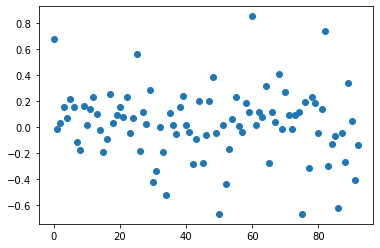

In [79]:
#予測と実際値の差をplot
y_pred=lr.predict(X_test)
a=[i for i in range(len(y_test))]

b=(y_pred-y_test)
plt.scatter(a,b)
print(y_pred-y_test)